In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.ticker as ticker
plt.style.use(f'/home/edsaa/Repositories/ReactiveBiomass/misc/edwin.mplstyle')

from math import floor, log10
from os import system

''' GLOBAL CONSTANTS '''
PI = 3.141592
BOLTZMANN = 1.380649E-23 #N·m/K
TEMP = 10 + 273.15 #K
g = 9.81 #m/s²


def sci_notation(num, decimal_digits=1, precision=None, exponent=None):
    """
    Returns a string representation of the scientific
    notation of the given number formatted for use with
    LaTeX or Mathtext, with specified number of significant
    decimal digits and precision (number of decimal digits
    to show). The exponent to be used can also be specified
    explicitly.
    """
    if exponent is None:
        exponent = int(floor(log10(abs(num))))
    coeff = round(num / float(10**exponent), decimal_digits)
    if precision is None:
        precision = decimal_digits

    return r"${0:.{2}f}\times10^{{{1:d}}}$".format(coeff, exponent, precision)

def p_notation(num) -> str:
    exponent = np.log10(num)
    return rf"$10^{{{exponent:.0f}}}$"

In [2]:
def dispCoef(D_m,alpha_L,U,n=1.0):
    return D_m + alpha_L*(U**n)

def poreVel(q, theta):
    return q/theta

def molecularDiff(visco,dp): 
    return (BOLTZMANN*TEMP)/(3*PI*visco*dp)

def attachmentRate(dc,theta,alpha,U,eta0): 
    return (3*(1-theta)*alpha*U*eta0)/(2*dc)

def collectorEff(etaD,etaI,etaG):
    return etaD + etaI + etaG

def collectorEfficiency_Diffusion(A_s,N_R,N_Pe,N_vdW):
    return 2.40 * (A_s**(1./3.)) * (N_R**-0.081) * (N_Pe**-0.715) * (N_vdW**0.052)

def collectorEfficiency_Interception(A_s,N_R,N_Pe,N_vdW):
    return 0.55 * A_s * (N_R**1.55) * (N_Pe**-0.125) * (N_vdW**0.125)

def collectorEfficiency_GDeposition(N_gr,N_R,N_Pe,N_vdW):
    return 0.475 * (N_gr**1.11)   * (N_R**-1.35)  * (N_Pe**-1.11)  * (N_vdW**0.053)

def happelParameter(theta):
    s = 1-theta
    s53 = s**(5./3.)
    s13 = s**(1./3.)
    s21 = s**2
    return (2*(1-s53))/(2 - (3*s13) + (3*s53) - (2*s21))

def noDim_SizeRatio(dp,dc):
    return dp/dc

def noDim_Péclet(q,dc,Dm):
     return q*dc/Dm

def noDim_vanderWaals(A):
    return A/(BOLTZMANN*TEMP)

def noDim_Gravitational(dp,rhof,rhop):
    return (PI*(dp**4)*(rhop-rhof)*g)/(12.*BOLTZMANN*TEMP)

In [3]:
'''CASE CONSTANTS'''
#Porosity
theta = 0.35 # adim
dc = 2.0E-3 #dc = np.power(10.0, np.arange(-5,-2.2,0.1))
A = 5.0E-21 # J = N·m
viscosity = 0.0008891 # N·s/m²
water_density = 999.79 # kg/m³
particle_density = 1050.0 # kg/m³ 
alpha = 0.01 # adim << favorable conditions

#Darcy flow velocity
I = np.power(10.0, np.arange(-4.7,0,0.05))
r = np.geomspace(5,250,150)
Ixx, ryy = np.meshgrid(I,r)

H = 10.
f = 10.
Qin = 0.24/86400.

In [4]:
def hydraulicCond_kozenycarman(dc:np.array) -> np.array:
    kappa = dc**2 * np.power(theta,3)/ (180 * np.power(1-theta, 2))
    return kappa * water_density * g / viscosity

K = hydraulicCond_kozenycarman(dc)
print(f"Hydraulic conductivity = {K:.2E} m/s")
print(f"log10(K) = {np.log10(K):.2f} ")

Hydraulic conductivity = 2.49E-02 m/s
log10(K) = -1.60 


In [5]:
def characteristic_q(I:np.array, r:np.array) -> np.array:
    return K*I + Qin*(1+f)/(4*r*H)

q = characteristic_q(Ixx, ryy)

In [6]:
def katt_dp_dc(dp:np.array, dc:np.array, q:np.array):

    #Molecular diffusion
    Dm  = molecularDiff(viscosity,dp)
    
    #Pore water velocity
    U   = poreVel(q,theta)
    
    #Non-dimensional numbers
    As  = happelParameter(theta)
    NR  = noDim_SizeRatio(dp,dc)
    NPe = noDim_Péclet(q,dc,Dm)
    NvW = noDim_vanderWaals(A)
    NGr = noDim_Gravitational(dp,water_density,particle_density)
    
    #Collector efficiency
    etaD = collectorEfficiency_Diffusion(As,NR,NPe,NvW)
    etaI = collectorEfficiency_Interception(As,NR,NPe,NvW)
    etaG = collectorEfficiency_GDeposition(NGr,NR,NPe,NvW)
    eta0 = collectorEff(etaD,etaI,etaG)
    
    #Attachment rate
    kAtt = attachmentRate(dc,theta,alpha,U,eta0)

    return kAtt

In [7]:
tau = (ryy*theta)/q
deltay = 0.75
NMonteCarlo = 100_000

dps = np.random.uniform(40, 200, NMonteCarlo) * 1e-9
decayRates =  np.power(10.0, np.random.normal(-0.48, 0.61, NMonteCarlo)) / 86400.0

from contourpy import contour_generator
contours = []

import os
import pickle

if os.path.exists("contours_montecarlo.pkl"):
    with open("contours_montecarlo.pkl", 'rb') as f:
        oldmontecarlo = pickle.load(f)
        sampledI = oldmontecarlo["sampledI"]
        contours = oldmontecarlo["contours"]
        sampledContours = oldmontecarlo["sampledContours"]

else:
    sampledI = np.power(10, np.linspace(-4, -0.9, 12))
    sampledContours = np.zeros((NMonteCarlo,len(sampledI)))

    for i, (decayRate, dp) in enumerate(zip(decayRates,dps)):
        katt = katt_dp_dc(dp,dc,q)
        Ce = Qin/(q*deltay*H) * np.exp(-(decayRate + katt)*tau)
        contour = contour_generator(x = Ixx, y=ryy, z = -np.ma.log10(Ce)).lines(4.0)
        if len(contour) > 0:
            contour = contour[0].T
            contours.append(contour)
            sampledContours[i] = np.interp(sampledI, contour[0], contour[1])

In [8]:
## Save the data to not having to run the N realizations again
with open("contours_montecarlo.pkl", 'wb') as f:
    pickle.dump(
        {"contours":contours,
         "sampledI":sampledI,
         "sampledContours":sampledContours} ,f)

In [9]:
## This comes from the calculation in Heatmap_setbackDistance.ipynb
with open("contour_4logrs.pkl", 'rb') as f:
    sarscov2contour = pickle.load(f)
sarscov2contour = sarscov2contour[0].T

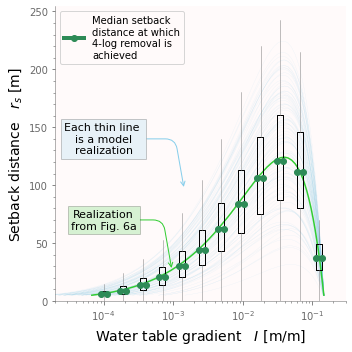

In [10]:
fig, ax = plt.subplots(figsize=(5,5))

for contour in contours[:100]:
    ax.plot(*contour, lw=0.1, c="skyblue", alpha=0.5, zorder=1)
    #break

ax.plot(*sarscov2contour, lw=1.5, zorder=2, c="limegreen")

bxp = ax.boxplot(sampledContours, 
    positions=sampledI, 
    widths=0.2*sampledI, 
    showcaps=False,
    whiskerprops=dict(lw=0.5, c="gray"),
    medianprops=dict(lw=4.0, c="seagreen", marker="o"),
    zorder=3, sym="")

bxp['medians'][0].set_label("Median setback\ndistance at which\n4-log removal is\nachieved")
ax.legend(fontsize=10)

ax.annotate('Each thin line \nis a model\nrealization', 
    xy=(1.5e-3, 90), 
    xytext=(1.0e-4, 140), xycoords='data', 
    fontsize=11, ha='center', va='center',
    bbox=dict(boxstyle='square', fc='skyblue',alpha=0.20),
    arrowprops=dict(arrowstyle="->",
            shrinkA=0, shrinkB=10, ec="skyblue",
            connectionstyle="angle,angleA=0,angleB=100,rad=10"))

ax.annotate('Realization\nfrom Fig. 6a', 
    xy=(1.0e-3, 20), 
    xytext=(1.0e-4, 70), xycoords='data',  
    fontsize=11, ha='center', va='center',
    bbox=dict(boxstyle='square', fc='limegreen',alpha=0.20),
    arrowprops=dict(arrowstyle="->",
            shrinkA=0, shrinkB=10, ec="limegreen",
            connectionstyle="angle,angleA=0,angleB=100,rad=10"))

ax.set_xscale('log')
ax.set_xlim((I.min(), 3e-1))
ax.set_xlabel(r"Water table gradient   $I$ [m/m]")
ax.set_ylim(bottom=0)
ax.minorticks_on()
ax.set_ylabel(r"Setback distance   $r_s$ [m]")

ax.spines.right.set_visible(False)
plt.tight_layout()
#plt.savefig("Figures/MonteCarlo_setbackDistance.pdf", bbox_inches='tight', pad_inches=0.05)
#ax.grid(True, which="both", axis='y', alpha=0.2)
plt.show()

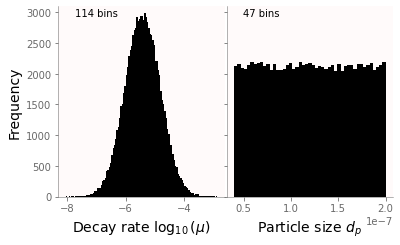

In [11]:
fig, axs = plt.subplots(1,2, sharey=True, figsize=(6,3.5), gridspec_kw={"wspace":0.01})
ax = axs[0]
n, bins, _ = ax.hist(np.log10(decayRates), bins="scott")
ax.set_xlabel(r"Decay rate $\log_{10}{(\mu)}$")
ax.set_ylabel(r"Frequency")
ax.spines.right.set_visible(False)
ax.text(0.1, 0.99, f"{len(n)} bins", 
    ha="left", va="top", fontsize=10, transform=ax.transAxes)

ax = axs[1]
n, bins, _ = ax.hist(dps, bins="scott")
ax.set_xlabel(r"Particle size $d_p$")
ax.spines.right.set_visible(False)
ax.text(0.1, 0.99, f"{len(n)} bins",
    ha="left", va="top", fontsize=10, transform=ax.transAxes)
#plt.savefig("Figures/MonteCarlo_inputparameters.pdf", bbox_inches='tight', pad_inches=0.05)
ax.set_ylim(top=3100)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


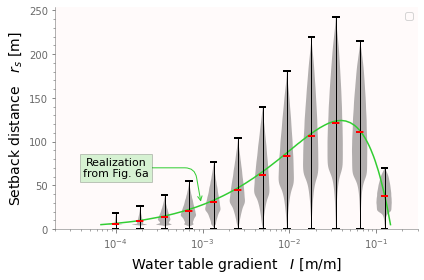

In [12]:
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(*sarscov2contour, lw=1.5, zorder=2, c="limegreen")

vpl = ax.violinplot(sampledContours, 
    positions=sampledI, 
    widths=0.4*sampledI, 
    showmeans=False,
    showmedians=True,
    showextrema=True)

vpl['cbars'].set(lw=1.0)
vpl['cmedians'].set(lw=2.0, color='red', ls='dashed')

ax.legend(fontsize=10)

ax.annotate('Realization\nfrom Fig. 6a', 
    xy=(1.0e-3, 20), 
    xytext=(1.0e-4, 70), xycoords='data',  
    fontsize=11, ha='center', va='center',
    bbox=dict(boxstyle='square', fc='limegreen',alpha=0.20),
    arrowprops=dict(arrowstyle="->",
            shrinkA=0, shrinkB=10, ec="limegreen",
            connectionstyle="angle,angleA=0,angleB=100,rad=10"))

ax.set_xscale('log')
ax.set_xlim((I.min(), 3e-1))
ax.set_xlabel(r"Water table gradient   $I$ [m/m]")
ax.set_ylim(bottom=0)
ax.minorticks_on()
ax.set_ylabel(r"Setback distance   $r_s$ [m]")
ax.spines.right.set_visible(False)
plt.tight_layout()
plt.show()

In [66]:
from ipywidgets import interact_manual, IntSlider

@interact_manual(ival=IntSlider(min=0, max=len(sampledContours[0]),value=9))
def plot_histogram(ival):
    fig,axs = plt.subplots(3,1, figsize=(5,8), gridspec_kw={"hspace":0.1}, sharex=True, height_ratios=[0.4,1,2])
    
    ## Boxplot
    ax = axs[0]
    bxp = ax.boxplot(sampledContours.T[ival],
        widths=0.25, vert=False,
        showcaps=True,
        whiskerprops=dict(lw=0.5, c="gray"),
        medianprops=dict(lw=4.0, c="seagreen", marker="o"),
        zorder=3, sym="")
    
    ax.axis('off')
    ax.spines.left.set_visible(False)
    ax.spines.bottom.set_visible(False)

    ## Histogram
    ax = axs[1]
    n, bins, _ = ax.hist(sampledContours.T[ival], bins="scott", density=True, cumulative=False, 
        alpha=0.30, color="k", histtype="stepfilled")
    ax.legend(labels=[f"Histogram\n  {len(n)} bins"], fontsize=10)
    ax.minorticks_on()

    ## Cummulative histogram
    ax = axs[2]
    n, bins, _ = ax.hist(sampledContours.T[ival], 
        bins=len(n), density=True, cumulative=True,
        histtype="stepfilled", color="rosybrown",
        alpha=0.50, label="Cumulative\nhistogram")
    rs75 = np.quantile(sampledContours.T[ival], 0.75)
    rs50 = np.quantile(sampledContours.T[ival], 0.50)

    ax.legend(fontsize=10, loc="upper left")
    ax.set_ylim(0, 0.999)
    ax.text(rs75-10, 0.02, f"Third quartile: $r_s = ${rs75:.0f} m", 
        ha='left', va='bottom', color="darkviolet", rotation=90, fontsize=11)

    ax.text(rs50-10, 0.02, f"Median: $r_s = ${rs50:.0f} m", 
        ha='left', va='bottom', color="seagreen", rotation=90, fontsize=11)

    ax.minorticks_on()


    # General config
    for ax in axs: 
        ax.spines.right.set_visible(False)
        ax.set_xlim(0, 249)
        ax.axvline(x=rs75, lw=1.0, color="darkviolet", ls="dotted")#, ymin=0, ymax=0.75,)
        ax.axvline(x=rs50, lw=1.0, color="seagreen", ls="dashed")#, ymin=0, ymax=0.75,)
    
    ax.set_xlabel(r"Setback distance   $r_s$ [m]")
    
    fig.suptitle(f"$I = ${sci_notation(sampledI[ival])}", y=0.92)
    fig.supylabel(f"Relative frequency (sample size = {p_notation(NMonteCarlo)})", 
        x=-0.05, fontsize=14)
    
    plt.savefig("Figures/MonteCarlo_histogram.pdf", bbox_inches='tight', pad_inches=0.05)
    plt.show()

interactive(children=(IntSlider(value=9, description='ival', max=12), Button(description='Run Interact', style…